In [1]:
import torch
import numpy as np

In [2]:
from torch import nn, optim as opts
from plasma.training import Trainer, metrics, callbacks, data, losses
from plasma.modules import *
from tensorflow.keras.datasets import mnist

In [3]:
(x, y), _ = mnist.load_data()

x = x[(y <= 2)] / 127.5 - 1
y = y[(y <= 2)]

class Data(data.StandardDataset):
    
    def get_len(self):
        return x.shape[0]
    
    def get_item(self, idx):
        return x[idx, None], y[idx]

In [4]:
model = nn.Sequential(*[
    PrimaryGroupConv2d(1, 8, kernel_size=5, padding=2),
    GEBatchNorm2d(8),
    nn.ReLU(inplace=True),
    
    GEConv2d(8, 16, kernel_size=5, padding=2),
    GEBatchNorm2d(16),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(2, 2),
    
    GEConv2d(16, 16, kernel_size=5, padding=2),
    GEBatchNorm2d(16),
    nn.ReLU(inplace=True),
    
    GEConv2d(16, 32, kernel_size=5, padding=2),
    GEBatchNorm2d(32),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(2, 2),
    
    GEConv2d(32, 32, kernel_size=5, padding=2),
    GEBatchNorm2d(32),
    nn.ReLU(inplace=True),
    
    Reshape(32, -1, 7, 7),
    GlobalAverage(rank=3),
    nn.Linear(32, 3),
])

model.cuda(0)

Sequential(
  (0): PrimaryGroupConv2d(in_channels=1, out_channels=8, kernel=5, radius=3.5355339059327373, n_ring=5, stride=1, padding=2, bias=True)
  (1): GEBatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): GEConv2d(in_channels=8, out_channels=16, kernel=5, radius=3.5355339059327373, n_ring=5, stride=1, padding=2, dilation=1, groups=1, bias=True)
  (4): GEBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): GEConv2d(in_channels=16, out_channels=16, kernel=5, radius=3.5355339059327373, n_ring=5, stride=1, padding=2, dilation=1, groups=1, bias=True)
  (8): GEBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): GEConv2d(in_channels=16, out_channels=32, kernel=5, radius=3.5355339059327373, n_ring=5, stride=1, padding=2, dilation=

In [5]:
loss = losses.cross_entropy_fn()

In [6]:
#opt = opts.RMSprop(model.parameters())
opt = opts.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

In [7]:
trainer = Trainer(model, opt, loss, metrics=[metrics.accuracy], x_device="cuda:0", y_device="cuda:0")

In [8]:
cbs = [
    #callbacks.LrFinder(min_lr=1e-5, max_lr=1, epochs=1)
    #callbacks.WarmRestart(1e-6, 0.1, factor=2, cycles=2, snapshot=False),
    #callbacks.CLR(1e-5, 4),
    #callbacks.TrainingScheduler(epochs=1)
]

In [9]:
trainer.fit(Data(), callbacks=cbs, batch_size=64)

epoch 1



epoch 2



epoch 3


KeyboardInterrupt: 

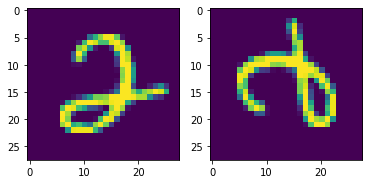

((1, 28, 28), 1.0, -1.0)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

a = Data()[6][0]
ar = np.rot90(a, axes=[1, 2])
ar = np.copy(ar)

_, ax = plt.subplots(ncols=2)
ax[0].imshow(a[0])
ax[1].imshow(ar[0])
plt.show()
a.shape, a.max(), a.min()

In [28]:
img = torch.tensor(a[None], dtype=torch.float, device="cuda:0")
model.eval()(img)

tensor([[-2.1264, -2.5634,  6.2873]], device='cuda:0', grad_fn=<AddmmBackward>)

In [29]:
img = torch.tensor(ar[None], dtype=torch.float, device="cuda:0")
model.eval()(img)

tensor([[-2.1264, -2.5634,  6.2873]], device='cuda:0', grad_fn=<AddmmBackward>)

(0.9921568627450981, -1.0)

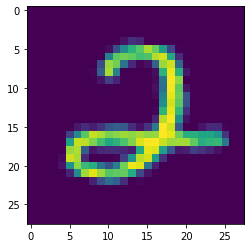

In [30]:
from albumentations import Rotate

r = Rotate(limit=(-10, -10), border_mode=1, p=1)
ar30 = r(image=a[0])["image"]

plt.imshow(ar30)
ar30.max(), ar30.min()

In [31]:
img = torch.tensor(ar30[None, None], dtype=torch.float, device="cuda:0")
model.eval()(img)

tensor([[-1.9504, -2.6120,  6.1069]], device='cuda:0', grad_fn=<AddmmBackward>)